<a href="https://colab.research.google.com/github/Ailton3112/glp/blob/main/OLD_RevGas_Prediction_FAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REVGÁS - Prediction FAST

* Sources
  - [Using machine learning to predict the next purchase date for an individual retail customer](http://www.scielo.org.za/scielo.php?script=sci_arttext&pid=S2224-78902020000300008)
  - [Predicting Next Purchase Day](https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027)
  - [Using Machine Learning to Predict Customers’ Next Purchase Day](https://towardsdatascience.com/using-machine-learning-to-predict-customers-next-purchase-day-7895ad49b4db)

### Experimentações a fazer

*   Experimentar a média por estado e média por cliente para predição 
*   Experimentar a média móvel 



In [ ]:
import pandas as pd
import numpy
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Carrega dataset

In [ ]:
## LOCAL DA MÁQUINA
dataset_path = '/Users/ailtonrodrigues/Desktop/REVGAS/input/produtos_clientes.csv'

dataset_ori = pd.read_csv(dataset_path)

## GDRIVE
#dataset_ori = pd.read_csv('/content/drive/MyDrive/REVGAS/dados/produtos_clientes.csv',delimiter = ',',low_memory=False)


### Visualiza Dataset

In [ ]:
dataset_ori.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state
0,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-04-09 22:17:37,Teresina,Piauí
1,29293,1,GLP 13KG,40.0,Dinheiro,40.00,40.0,2013-05-18 23:12:27,Teresina,Piauí
2,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-06-25 22:21:47,Teresina,Piauí
3,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-08-11 21:51:12,Teresina,Piauí
4,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-10-17 22:57:38,Teresina,Piauí


### Seta tipos de atributos

In [ ]:
dataset_ori['client_id'] = pd.to_numeric(dataset_ori['client_id'])
dataset_ori['quantity_product'] = pd.to_numeric(dataset_ori['quantity_product'], errors='coerce')
dataset_ori['product'] = dataset_ori['product'].astype('category')
dataset_ori['value_product'] = pd.to_numeric(dataset_ori['value_product'], errors='coerce')
dataset_ori['payments_values'] = pd.to_numeric(dataset_ori['payments_values'], errors='coerce')
dataset_ori['total'] = dataset_ori['total'].astype('float32')
dataset_ori['date'] = dataset_ori['date'].astype('datetime64')
dataset_ori['city'] = dataset_ori['city'].astype('category')
dataset_ori['state'] = dataset_ori['state'].astype('category')

### Filtra DATASET por estado e produto

In [ ]:
dataset = dataset_ori.query("(state=='Piauí') & (quantity_product<=2) & (product=='GLP 13KG')").reset_index(drop=True)
dataset.shape

(609599, 10)

### Descreve dados estatísticos do dataset já filtrado

In [ ]:
dataset.describe()

,client_id,quantity_product,value_product,payments_values,total
count,6.095990e+05,609599.000000,609599.000000,605553.000000,609599.000000
mean,1.310892e+05,1.085617,71.864565,78.335886,78.497437
std,1.807708e+05,0.279798,18.440122,31.776523,31.935467
min,2.929300e+04,1.000000,0.780000,0.780000,0.780000
25%,4.668200e+04,1.000000,60.000000,60.000000,60.000000
50%,6.443800e+04,1.000000,70.000000,72.000000,72.000000
75%,1.353510e+05,1.000000,80.000000,85.000000,85.000000
max,1.243195e+06,2.000000,950.000000,2505.000000,2505.000000


In [ ]:
dataset.info()

In [ ]:
dataset.isnull().sum()

client_id              0
quantity_product       0
product                0
value_product          0
payments               0
payments_values     4046
total                  0
date                   0
city                   0
state                  0
dtype: int64

In [ ]:
dataset['quantity_product'] = dataset['quantity_product'].fillna(1)
dataset['value_product'] = (dataset['value_product'].fillna(dataset['value_product'].mean())
)
dataset['payments_values'] = (
    dataset['payments_values'].fillna(dataset['payments_values'].mean())
)

In [ ]:
dataset.isnull().sum()

client_id           0
quantity_product    0
product             0
value_product       0
payments            0
payments_values     0
total               0
date                0
city                0
state               0
dtype: int64

### Organiza os dados de forma ascendente

In [ ]:
dataset.sort_values(['client_id', 'date'], ascending=True, inplace=True)

In [ ]:
dataset.shape

(609599, 10)

In [ ]:
dataset.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state
0,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-04-09 22:17:37,Teresina,Piauí
1,29293,1.0,GLP 13KG,40.0,Dinheiro,40.0,40.0,2013-05-18 23:12:27,Teresina,Piauí
2,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-06-25 22:21:47,Teresina,Piauí
3,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-08-11 21:51:12,Teresina,Piauí
4,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-10-17 22:57:38,Teresina,Piauí


### Calcula a last_order (dias entre pedidos)

In [ ]:
last_order = numpy.zeros(shape=(dataset.shape[0],))
client = -1
last_date = None
count = 0
for i, r in dataset.iterrows():
  if r['client_id'] == client:
    last_order[count] = (r['date']-last_date)/numpy.timedelta64(1, 'D')
  else:
    client = r['client_id']
  last_date = r['date']
  count += 1

dataset['last_order'] = last_order


In [ ]:
dataset.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state,last_order,SMA5
1,29293,1.0,GLP 13KG,40.0,Dinheiro,40.0,40.0,2013-05-18 23:12:27,Teresina,Piauí,0.000000,NaN
2,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-06-25 22:21:47,Teresina,Piauí,37.964815,NaN
3,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-08-11 21:51:12,Teresina,Piauí,46.978762,NaN
4,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-10-17 22:57:38,Teresina,Piauí,67.046134,NaN
5,29293,1.0,GLP 13KG,40.0,Dinheiro,40.0,40.0,2013-12-03 20:31:04,Teresina,Piauí,46.898218,NaN


In [ ]:
dataset.drop(dataset[dataset['last_order']<=0].index, inplace=True)

In [ ]:
dataset.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state,last_order,SMA5
2,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-06-25 22:21:47,Teresina,Piauí,0.000000,NaN
3,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-08-11 21:51:12,Teresina,Piauí,46.978762,NaN
4,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-10-17 22:57:38,Teresina,Piauí,67.046134,NaN
5,29293,1.0,GLP 13KG,40.0,Dinheiro,40.0,40.0,2013-12-03 20:31:04,Teresina,Piauí,46.898218,NaN
6,29293,1.0,GLP 13KG,40.0,Dinheiro,40.0,40.0,2013-12-03 20:31:13,Teresina,Piauí,0.000104,NaN


In [ ]:
#from sklearn import preprocessing

In [ ]:
# scaler = MinMaxScaler()
# y = scaler.fit_transform(dataset['last_order'].values.reshape(-1,1))
#y = preprocessing.normalize(dataset['last_order'].values.reshape(-1,1))
#last_order = pd.DataFrame(y)
#dataset.boxplot(column=['last_order']) 

### Linhas e colunas do dataset

In [ ]:
dataset.shape

(534866, 11)

### BoxPlot da coluna  last_order

<AxesSubplot:>

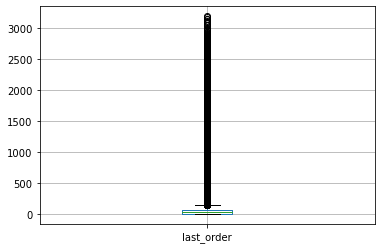

In [ ]:
dataset.boxplot(column=['last_order']) 

### Média e Desvio Padrão do atributo "lastorder" - SEM REMOÇÃO DE OUTLIERS

In [ ]:
# Using DataFrame.mean() method to get column average last order

df_last_order_media = dataset["last_order"].mean() 
print("MÉDIA DE PEDIDOS (PI) ................ :", df_last_order_media)

df_dsp = dataset["last_order"].std()
print("DESVIO PADRÃO (PI).....................:", df_dsp)

MÉDIA DE PEDIDOS (PI) ................ : 70.86790130201162
DESVIO PADRÃO (PI).....................: 171.11901636810057


In [ ]:
dataset.drop(dataset[dataset['last_order']<=0].index, inplace=True)

In [ ]:
dataset.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state,last_order
0,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-04-09 22:17:37,Teresina,Piauí,0.000000
1,29293,1.0,GLP 13KG,40.0,Dinheiro,40.0,40.0,2013-05-18 23:12:27,Teresina,Piauí,39.038079
2,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-06-25 22:21:47,Teresina,Piauí,37.964815
3,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-08-11 21:51:12,Teresina,Piauí,46.978762
4,29293,1.0,GLP 13KG,45.0,Dinheiro,45.0,45.0,2013-10-17 22:57:38,Teresina,Piauí,67.046134


In [ ]:
lo = dataset['last_order'].to_frame()
  
# calculating simple moving average
# using .rolling(window).mean() ,
# with window size = 30
lo['SMA30'] = lo['last_order'].rolling(30).mean()
  
# removing all the NULL values using 
# dropna() method
lo.dropna(inplace=True)
  
# printing Dataframe
lo.head()

,last_order,SMA30
29,36.331169,45.395495
30,36.009259,46.595804
31,37.960486,46.559884
32,31.051678,46.329446
33,35.645139,45.951659


In [ ]:
# # moving average of 5 days using .plot() method
# lo[['last_order', 'SMA60']].plot(label='lo', 
#                                   figsize=(16, 8))

### Remoção de OUTLIERS

In [ ]:
#dataset= remove_outlier(dataset,"last_order")

Q1 = dataset['last_order'].quantile(0.25)
Q3 = dataset['last_order'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (dataset['last_order'] >= Q1 - 1.5 * IQR) & (dataset['last_order'] <= Q3 + 1.5 *IQR)
dataset= dataset.loc[filter] 
#dataset = dataset[dataset['last_order']<dataset['last_order'].quantile(0.95)]
dataset.shape


(464602, 11)

### Média e Desvio Padrão do atributo "lastorder" - PÓS REMOÇÃO DE OUTLIERS

In [ ]:
# Using DataFrame.mean() method to get column average last order

df_last_order_media = dataset["last_order"].mean() 
print("Valor da Média................ :", df_last_order_media)

df_dsp = dataset["last_order"].std()
print("Valor de desvio padrão.........:", df_dsp)

Valor da Média................ : 28.326438152255786
Valor de desvio padrão.........: 27.289885443372576


<AxesSubplot:>

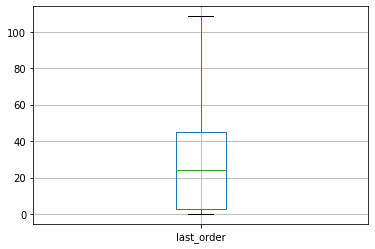

In [ ]:
dataset.boxplot(column=['last_order']) 

<AxesSubplot:ylabel='Frequency'>

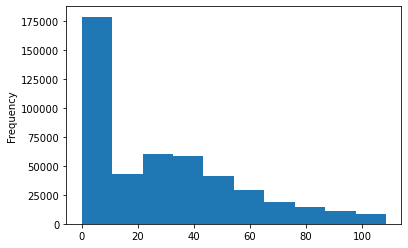

In [ ]:
dataset['last_order'].plot(kind='hist')

In [ ]:
df_all = dataset.describe()
df_all

,client_id,quantity_product,value_product,payments_values,total,last_order
count,4.646020e+05,464602.000000,464602.000000,464602.000000,464602.000000,464602.000000
mean,1.161966e+05,1.103506,71.518267,79.257367,79.419807,28.326438
std,1.532587e+05,0.304619,18.010568,32.789263,33.082302,27.289885
min,2.929300e+04,1.000000,3.000000,3.000000,3.000000,0.000012
25%,4.614500e+04,1.000000,60.000000,60.000000,60.000000,2.758837
50%,6.244300e+04,1.000000,70.000000,72.000000,72.000000,23.956759
75%,1.276650e+05,1.000000,80.000000,88.000000,88.000000,45.074878
max,1.242571e+06,2.000000,950.000000,1450.000000,1450.000000,108.548912


In [ ]:
for p in dataset['payments'].unique():
  print(p)

Dinheiro
Carteira
Cartão Credishop
Cartão Visa
Cheque
Cartão Master
Cartão Hiper
Cartão Elo
DinheiroDinheiro
Carteira,Cartão Master
PIX
Crédito de Cliente
DinheiroCrédito de Cliente
Boleto Bancário
Cartão de Crédito
Cartão de Débito
Carteira,Crédito de Cliente
Crédito de Cliente,Cartão de Débito
Carteira,Cartão de Crédito
Dinheiro de Débito
Cheque,Cartão Visa
Cartão Outro
Dinheiro Outro
Cartão Visa,Cartão Outro
Cartão
Cartão Visa,Cartão Hiper
Cartão Elo,Cartão Outro
Dinheiro Elo
Carteira,Cartão
Carteira,Cartão Outro
Dinheiro Credishop
Vale Gás
Vale Gás,Vale Gás
Cartão de Crédito,Cartão de Débito
Dinheiro de Crédito
Carteira,Cartão Hiper
DinheiroCheque
DinheiroVale Gás
Transferência Bancária
Cartão de Crédito,Cartão de Crédito
Carteira,Cartão Credishop
Cartão Credishop,Cartão de Débito
DinheiroPIX
DinheiroTransferência Bancária


In [ ]:
dataset['payments'].nunique()

44

In [ ]:
payment_terms = {
    'Débito': 'Débito',
    'Pix': 'Pix',
    'Dinheiro': 'Dinheiro',
    'Crédito': 'Crédito',
    'Cartão': 'Crédito',
    'Cheque': 'Cheque',
    'Vale': 'Vale',
    'Carteira': 'Carteira',
    'Transferência': 'Transferência Bancária'
}
for key, value in payment_terms.items():
  dataset.loc[dataset['payments'].str.contains(
      key, case=False
  ), 'payments'] = value

In [ ]:
dataset['payments'].unique()

array(['Dinheiro', 'Carteira', 'Crédito', 'Cheque', 'Pix',
       'Boleto Bancário', 'Débito', 'Vale', 'Transferência Bancária'],
      dtype=object)

In [ ]:
dataset['payments'] = dataset['payments'].astype('category')

In [ ]:
product_terms = {
    r'^.*GLP\s?13\s?KG.*$': r'GLP 13 KG'
}

for key, value in product_terms.items():
  dataset['product'] = (
      dataset['product'].str.replace(key, value)
  )

In [ ]:
dataset['product'].unique()

array(['GLP 13 KG'], dtype=object)

In [ ]:
dataset = pd.get_dummies(
      dataset, prefix='d', columns=['payments', 'city', 'state']
 
)

In [ ]:
dataset.head()

,client_id,quantity_product,product,value_product,payments_values,total,date,last_order,d_Boleto Bancário,d_Carteira,...,d_Pernambuco,d_Piauí,d_Rio Grande do Norte,d_Rio Grande do Sul,d_Rio de Janeiro,d_Rondônia,d_Santa Catarina,d_Sergipe,d_São Paulo,d_Tocantins
1,29293,1.0,GLP 13 KG,40.0,40.0,40.0,2013-05-18 23:12:27,39.038079,0,0,...,0,1,0,0,0,0,0,0,0,0
2,29293,1.0,GLP 13 KG,45.0,45.0,45.0,2013-06-25 22:21:47,37.964815,0,0,...,0,1,0,0,0,0,0,0,0,0
3,29293,1.0,GLP 13 KG,45.0,45.0,45.0,2013-08-11 21:51:12,46.978762,0,0,...,0,1,0,0,0,0,0,0,0,0
4,29293,1.0,GLP 13 KG,45.0,45.0,45.0,2013-10-17 22:57:38,67.046134,0,0,...,0,1,0,0,0,0,0,0,0,0
5,29293,1.0,GLP 13 KG,40.0,40.0,40.0,2013-12-03 20:31:04,46.898218,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Como só tem uma categoria de producos (GLP 13 KG) não vamos usar a coluna
X = dataset.drop(['client_id', 'last_order', 'date', 'product'], axis=1)
Y = dataset['last_order']

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=4
)
print("Tamanho do set train:",len(x_train))
print("Tamanho do set test:",len(x_test))

Tamanho do set train: 325221
Tamanho do set test: 139381


In [ ]:
x_train= x_train.T.drop_duplicates().T
#x_train.head()
x_test= x_test.T.drop_duplicates().T

In [ ]:
duplicate_columns_test = x_test.columns[x_test.columns.duplicated()]
duplicate_columns_test

Index(['d_Amapá', 'd_Rio de Janeiro', 'd_São Paulo'], dtype='object')

In [ ]:
duplicate_columns_train = x_train.columns[x_train.columns.duplicated()]
duplicate_columns_train

Index(['d_Amapá', 'd_Rio de Janeiro', 'd_São Paulo'], dtype='object')

In [ ]:
print("Tamanho do set train:",len(x_train))
print("Tamanho do set test:",len(x_test))

Tamanho do set train: 325221
Tamanho do set test: 139381


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
scaler = MinMaxScaler()
columns = [
    'quantity_product', 'value_product', 'payments_values', 'total',
]

x_train[columns] = scaler.fit_transform(x_train[columns])
x_test[columns] = scaler.transform(x_test[columns])

In [ ]:
x_train.head()

,quantity_product,value_product,payments_values,total,d_Boleto Bancário,d_Carteira,d_Cheque,d_Crédito,d_Dinheiro,d_Débito,...,d_Pernambuco,d_Piauí,d_Rio Grande do Norte,d_Rio Grande do Sul,d_Rio de Janeiro,d_Rondônia,d_Santa Catarina,d_Sergipe,d_São Paulo,d_Tocantins
71267,0.0,0.091416,0.060651,0.060651,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
236946,0.0,0.080268,0.053254,0.053254,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
414708,0.0,0.070234,0.046598,0.046598,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
460567,0.0,0.069119,0.045858,0.045858,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
233812,0.0,0.069119,0.045858,0.045858,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
len(x_train.columns)

587

In [ ]:
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = yscaler.transform(y_test.values.reshape(-1, 1))

## Modelo 1: Regressão linear

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import sklearn


In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
r = LinearRegression()
r = r.fit(x_train, y_train)

In [ ]:
y_predicted = r.predict(x_test)
#y_predicted_train = r.predict(x_train)

In [ ]:
# scores = cross_val_score(r, x_train, y_train, scoring='r2', cv=5)
# scores   

array([-2.56449648e+16,  1.16952067e-01,  1.17424712e-01,  1.18500214e-01,
       -7.14195352e+16])

In [ ]:
# score = r.score(x_test, y_test)
# score

-1399739621774214.0

In [ ]:
from matplotlib import pyplot

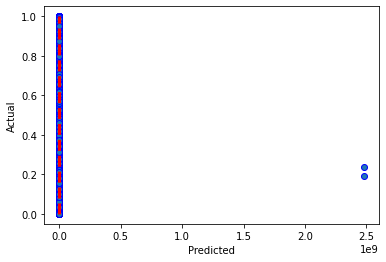

In [ ]:
fig, ax = pyplot.subplots()
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
pyplot.show()

## Modelo 2: Árvore de Regressão Linear

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)

DecisionTreeRegressor()

In [ ]:
y_predicted_d = dtr.predict(x_test)

In [ ]:
from matplotlib import pyplot

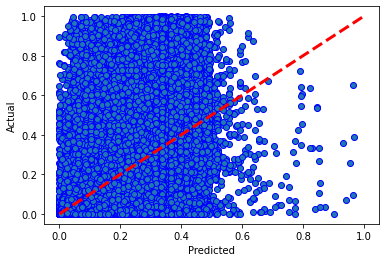

In [ ]:
fig, ax = pyplot.subplots()
ax.scatter(y_predicted_d, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
pyplot.show()

## Modelo 3: Rede neural

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
nnr = MLPRegressor(hidden_layer_sizes=(100, 50))
nnr.fit(x_train, y_train.ravel())


MLPRegressor(hidden_layer_sizes=(100, 50))

In [ ]:
y_predicted = nnr.predict(x_test)

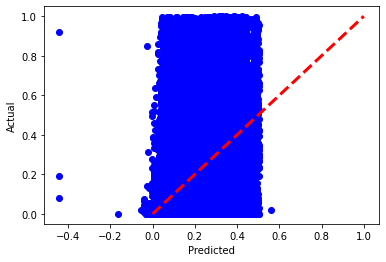

In [ ]:
fig, ax = pyplot.subplots()
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1),color="blue", label="original")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, color="red", label="predicted")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
pyplot.show()

## Modelo XGBoost Regressor

In [ ]:
!pip install xgboost

from xgboost import XGBRegressor


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-1.5.2-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl (1.3 MB)


In [ ]:
#duplicate_columns_test = x_train.columns[x_train.columns.duplicated()]
#duplicate_columns_test
x_train= x_train.T.drop_duplicates().T

In [ ]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

In [ ]:
#x_test= x_test.T.drop_duplicates().T
score = xgb.score(x_train, y_train)  
score

0.1860210778368494

In [ ]:
scores = cross_val_score(xgb, x_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


In [ ]:
x_test= x_test.T.drop_duplicates().T


In [ ]:
ypred = xgb.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
MSE: 3.35
print("RMSE: %.2f" % (mse**(1/2.0)))
RMSE: 1.83 


## Modelo LSTM

In [ ]:
import sys

!$sys.executable -m pip install tensorflow

In [ ]:
from tensorflow.python import tf2
from keras import distribute
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense,Bidirectional 


In [ ]:
## Filtra por cliente
def filter_client(idclient):
    filter = dataset.query("client_id==@idclient")

    #filter = (dataset['client_id'] == idclient) 
    ds = filter 
    return ds

In [ ]:
## Divide os dados
def split_client(df, percentagem):
    
    close_data = df['last_order'].values
    close_data = close_data.reshape((-1,1))
    
    split_percent = percentagem
    split = int(split_percent*len(close_data))
    
    close_train = close_data[:split]
    close_test  = close_data[split:]
    
    date_train = df['date'][:split]
    date_test =  df['date'][split:]

    return close_data,close_train,close_test,date_train,date_test

##Execução Prática

In [ ]:
### Filtrar por idcliente
#id = 29293 
#ds = filter_client(id)
ds = dataset
#ds.to_csv('29293.csv')

ds.head()

,client_id,quantity_product,product,value_product,payments_values,total,date,last_order,d_Boleto Bancário,d_Carteira,...,d_Pernambuco,d_Piauí,d_Rio Grande do Norte,d_Rio Grande do Sul,d_Rio de Janeiro,d_Rondônia,d_Santa Catarina,d_Sergipe,d_São Paulo,d_Tocantins
1,29293,1.0,GLP 13 KG,40.0,40.0,40.0,2013-05-18 23:12:27,39.038079,0,0,...,0,1,0,0,0,0,0,0,0,0
2,29293,1.0,GLP 13 KG,45.0,45.0,45.0,2013-06-25 22:21:47,37.964815,0,0,...,0,1,0,0,0,0,0,0,0,0
3,29293,1.0,GLP 13 KG,45.0,45.0,45.0,2013-08-11 21:51:12,46.978762,0,0,...,0,1,0,0,0,0,0,0,0,0
4,29293,1.0,GLP 13 KG,45.0,45.0,45.0,2013-10-17 22:57:38,67.046134,0,0,...,0,1,0,0,0,0,0,0,0,0
5,29293,1.0,GLP 13 KG,40.0,40.0,40.0,2013-12-03 20:31:04,46.898218,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
ds.shape

(464602, 591)

In [ ]:
ds['date'] = pd.to_datetime(ds['date'])
ds.set_axis(ds['date'], inplace=True)

In [ ]:
ds.shape

(464602, 591)

In [ ]:
### Divide os dados 
lastorder_data, lastorder_train, lastorder_test, date_train, date_test = split_client(ds,0.80)


In [ ]:
# 4 ultimos last order do cliente
look_back = 4

#forward_days = 4

train_generator = TimeseriesGenerator(lastorder_train, lastorder_train, length=look_back, batch_size=20)     
test_generator  = TimeseriesGenerator(lastorder_test, lastorder_test, length=look_back, batch_size=1)


In [ ]:
EPOCHS = 201
validation = 0.05

In [ ]:
from keras.callbacks import ReduceLROnPlateau #Learning rate scheduler for when we reach plateaus
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
from keras.layers import LSTM
import LSTM_Prep


Summary Statistics - ADF Test For Stationarity

ADF Stat is: -47.92050458326735.
P Val is: 0.0.
Critical Values (Significance Levels): 
1% : -3.43
5% : -2.862
10% : -2.567


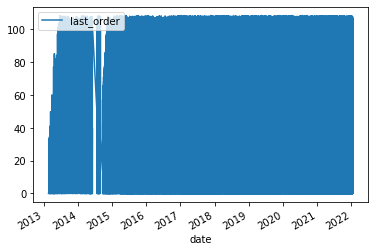

In [ ]:
split = 0.8
sequence_length = 4

data_prep = LSTM_Prep.Data_Prep(dataset = dataset)
rnn_df, validation_df = data_prep.preprocess_rnn(date_colname = 'date', numeric_colname = 'last_order', pred_set_timesteps = 4)


series_prep = LSTM_Prep.Series_Prep(rnn_df =  rnn_df, numeric_colname = 'last_order')
window, X_min, X_max = series_prep.make_window(sequence_length = sequence_length, 
                                               train_test_split = split, 
                                               return_original_x = True)

X_train, X_test, y_train, y_test = series_prep.reshape_window(window, train_test_split = split)

In [ ]:
# Epochs and validation split
EPOCHS = 201
validation = 0.05

# Instantiate the model
model = Sequential()

# Add the first layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), return_sequences = True,
        units = 100))

# Add the second layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), 
        units = 100))

# Add the output layer, simply one unit
model.add(Dense(
        units = 1,
        activation = 'sigmoid'))

model.compile(loss = 'mse', optimizer = 'adam')


# History object for plotting our model loss by epoch
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_split = validation,
          callbacks = [rlrop])
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Epoch 1/201
10587/10587 [==============================] - 135s 12ms/step - loss: 6.9923e-04 - val_loss: 1.5213e-04 - lr: 0.0010
Epoch 2/201
10587/10587 [==============================] - 111s 10ms/step - loss: 2.5796e-04 - val_loss: 1.4911e-04 - lr: 0.0010
Epoch 3/201
10587/10587 [==============================] - 105s 10ms/step - loss: 2.4745e-04 - val_loss: 1.5258e-04 - lr: 0.0010
Epoch 4/201
10587/10587 [==============================] - 112s 11ms/step - loss: 2.4426e-04 - val_loss: 1.5179e-04 - lr: 0.0010
Epoch 5/201
10587/10587 [==============================] - 112s 11ms/step - loss: 2.4307e-04 - val_loss: 1.5041e-04 - lr: 0.0010
Epoch 6/201
10587/10587 [==============================] - 109s 10ms/step - loss: 2.4220e-04 - val_loss: 1.5617e-04 - lr: 0.0010
Epoch 7/201
10587/10587 [==============================] - 110s 10ms/step - loss: 2.4189e-04 - val_loss: 1.5123e-04 - lr: 0.0010
Epoch 8/201
10587/10587 [==============================] - 112s 11ms/step - loss: 2.4177e-04 - va

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Creating our future object
future = LSTM_Prep.Predict_Future(X_test  = X_test, validation_df = validation_df, lstm_model = model)
# Checking its accuracy on our training set
future.predicted_vs_actual(X_min = X_min, X_max = X_max, numeric_colname = 'perc')
# Predicting 'x' timesteps out
future.predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'perc', timesteps_to_predict = 15, return_future = True)


In [ ]:
import sys
!$sys.executable -m pip install plotly
!$sys.executable -m pip install -U kaleido
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [ ]:
prediction = model.predict_generator(test_generator)

lastorder_train = lastorder_train.reshape((-1))
lastorder_test = lastorder_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = lastorder_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = lastorder_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show(renderer="colab")

In [ ]:
lastorder_data = lastorder_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = lastorder_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = ds['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [ ]:
num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
forecast_dates

## Simple practical Exemplo

###Regressão Linear

In [ ]:
def transform_record(client_id, dataframe, scaler, model, normalizer):
  df = dataframe[dataframe['client_id'] == client_id]
  df = df.iloc[-1:]
  X = df.drop(['client_id', 'last_order', 'date', 'product'], axis=1)
  date = df['date']
  columns = [
    'quantity_product', 'value_product', 'payments_values', 'total',
  ]
  X[columns] = scaler.transform(X[columns])
  y_predicted = model.predict(X.values)
  y = normalizer.inverse_transform(y_predicted.reshape(-1, 1))
  new_date = date.values[0] + (y[0] * numpy.timedelta64(1, 'D'))
  return new_date[0], date.values[0]

In [ ]:
new_date, old_date = transform_record(
    29293, dataframe=dataset, scaler=scaler, model=r, normalizer=yscaler
)

In [ ]:
import datetime

In [ ]:
n_date = datetime.datetime.fromtimestamp(
    new_date.item() / 10**9
).strftime('%Y.%m.%d')

o_date = datetime.datetime.fromtimestamp(
    old_date.item() / 10**9
).strftime('%Y.%m.%d')

In [ ]:
print(f'Última compra em: {o_date}. Próxima data de compra estimada em: {n_date}')

Última compra em: 2022.01.04. Próxima data de compra estimada em: 2022.02.13


### Rede Neural

In [ ]:
new_date, old_date = transform_record(
    29293, dataframe=dataset, scaler=scaler, model=nnr, normalizer=yscaler
)

In [ ]:
n_date = datetime.datetime.fromtimestamp(
    new_date.item() / 10**9
).strftime('%Y.%m.%d')

o_date = datetime.datetime.fromtimestamp(
    old_date.item() / 10**9
).strftime('%Y.%m.%d')

In [ ]:
print(f'Última compra em: {o_date}. Próxima data de compra estimada em: {n_date}')

Última compra em: 2022.01.04. Próxima data de compra estimada em: 2022.02.13
